In [7]:
import pandas as pd
from util import cross_validate
import matplotlib.pyplot as plt
import numpy as np

In [42]:
data = pd.read_csv('../data/imputed.csv')

target = ['EURWH_MBOE','OilEURWH_MBBL','GasEURWH_BCF']
X = data[[column for column in data.columns if column not in target]]
y = data['EURWH_MBOE']
xy = data[["Longitude", "Latitude"]]

In [40]:
from lightgbm import LGBMRegressor

best_params = {}
model = LGBMRegressor(n_estimators=500, learning_rate=0.1, max_depth=10, force_col_wise=True, verbose=-1)
            
predictions = cross_validate(model, X, y)

Mean RMSE: 449.6123022589888
Mean NRMSE: 0.42487813819454806
Mean Adjusted R^2: 0.5439629888649875


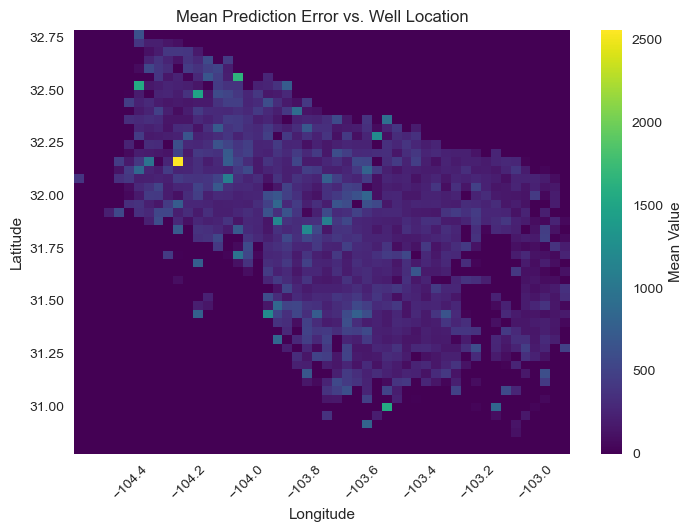

In [62]:
## Histogram of Error
error = np.abs(predictions - y)
coordinates = xy.values

# Define the number of bins in each direction
num_bins = 50

# Create a 2D histogram
hist, x_edges, y_edges = np.histogram2d(coordinates[:, 0], coordinates[:, 1], bins=num_bins, weights=error)

# Calculate the mean value within each bin
mean_values = hist / np.maximum(1, np.histogram2d(coordinates[:, 0], coordinates[:, 1], bins=num_bins)[0])

# Create a meshgrid for the plot
x_centers = (x_edges[:-1] + x_edges[1:]) / 2
y_centers = (y_edges[:-1] + y_edges[1:]) / 2
x_vals, y_vals = np.meshgrid(x_centers, y_centers)

# Plot the mean values
plt.pcolormesh(x_vals, y_vals, mean_values, cmap='viridis')
plt.colorbar(label='Mean Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xticks(rotation = 45)
plt.title('Mean Prediction Error vs. Well Location')
plt.show()

In [21]:
# Assessing spatial correlation of error
import geopandas as gpd
from pysal.explore import esda
from pysal.lib import weights

gdf = gpd.GeoDataFrame(
    X[["Longitude", "Latitude"]],
    geometry=gpd.points_from_xy(X['Longitude'], X['Latitude']),
    crs='EPSG:4326'
)

w = weights.KNN.from_dataframe(gdf, k=30)
w.transform = "R"

moran = esda.moran.Moran(error, w)
print(moran.p_sim)
print(moran.I)

0.001
0.08041414031549


C:\Users\mathw\AppData\Local\Temp\ipykernel_37396\564082353.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


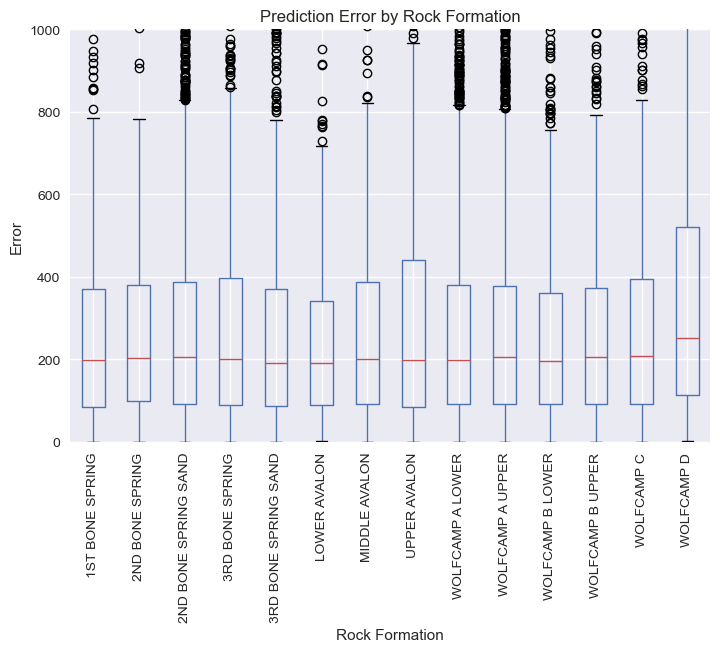

In [65]:
filtered = pd.read_csv('../data/filtered_2.csv')
plt.style.use('seaborn')

error_df = pd.concat((filtered["ENVInterval"], error), axis = 1)
error_df.columns = ["Rock", "Error"]
ax = error_df.boxplot(by = "Rock")

fig = ax.get_figure()
fig.suptitle('')
plt.ylim((0, 1000))
plt.xticks(rotation = 90)
plt.title("Prediction Error by Rock Formation")
plt.xlabel("Rock Formation")
plt.ylabel("Error")
plt.show()

In [74]:
from scipy.stats import ranksums

error_df = error_df.dropna(axis = 0)

for type in filtered["ENVInterval"].unique():
    print(ranksums(error_df[error_df["Rock"] == type]["Error"], error_df[error_df["Rock"] == "WOLFCAMP D"]["Error"]))

RanksumsResult(statistic=-2.1117963164442477, pvalue=0.03470392338853738)
RanksumsResult(statistic=-2.330337785291829, pvalue=0.019788305186086545)
RanksumsResult(statistic=-2.1096429201849087, pvalue=0.034889124475560224)
RanksumsResult(statistic=-2.0358799306350224, pvalue=0.04176241356155517)
RanksumsResult(statistic=-2.3982079301524286, pvalue=0.01647550978765553)
RanksumsResult(statistic=-2.0398598016259717, pvalue=0.04136429151179219)
RanksumsResult(statistic=-2.348583723913879, pvalue=0.018844961972933158)
RanksumsResult(statistic=-1.9206284321830152, pvalue=0.05477856805117501)
RanksumsResult(statistic=0.0, pvalue=1.0)
RanksumsResult(statistic=-1.8468395333378733, pvalue=0.06477040036803586)
RanksumsResult(statistic=-1.7791354282387666, pvalue=0.07521756157773715)
RanksumsResult(statistic=-2.1356120725896557, pvalue=0.0327110465758335)
RanksumsResult(statistic=-1.3452491115724707, pvalue=0.17854480117030946)
RanksumsResult(statistic=nan, pvalue=nan)
RanksumsResult(statistic=-1.

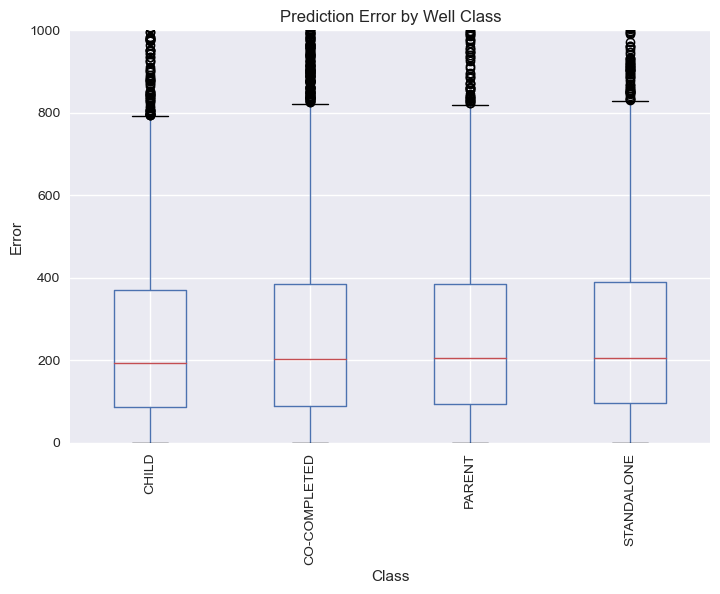

In [60]:
error_df = pd.concat((filtered["ParentChildSameZone"], error), axis = 1)
error_df.columns = ["Type", "Error"]
ax = error_df.boxplot(by = "Type")

fig = ax.get_figure()
fig.suptitle('')
plt.ylim((0, 1000))
plt.xticks(rotation = 90)
plt.title("Prediction Error by Well Class")
plt.xlabel("Class")
plt.ylabel("Error")
plt.show()

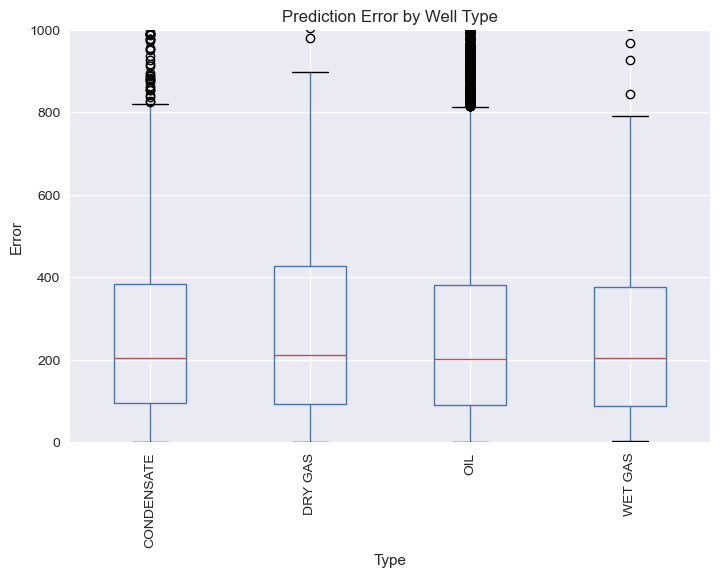

In [61]:
filtered['ENVProdWellType']= filtered['ENVProdWellType'].replace({'LIQUIDS RICH GAS (10-40% WH LIQUIDS)': 'CONDENSATE',
                                                           'OIL (40%+ WH LIQUIDS)': 'OIL',
                                                           'DRY GAS (0-1% WH LIQUIDS)':'DRY GAS',
                                                           'WET GAS (1-10% WH LIQUIDS)':'WET GAS'})

error_df = pd.concat((filtered["ENVProdWellType"], error), axis = 1)
error_df.columns = ["Type", "Error"]
ax = error_df.boxplot(by = "Type")

fig = ax.get_figure()
fig.suptitle('')

plt.ylim((0, 1000))
plt.xticks(rotation = 90)
plt.title("Prediction Error by Well Type")
plt.xlabel("Type")
plt.ylabel("Error")
plt.show()

Text(0.5, 1.0, 'Importance of Predictive Features')

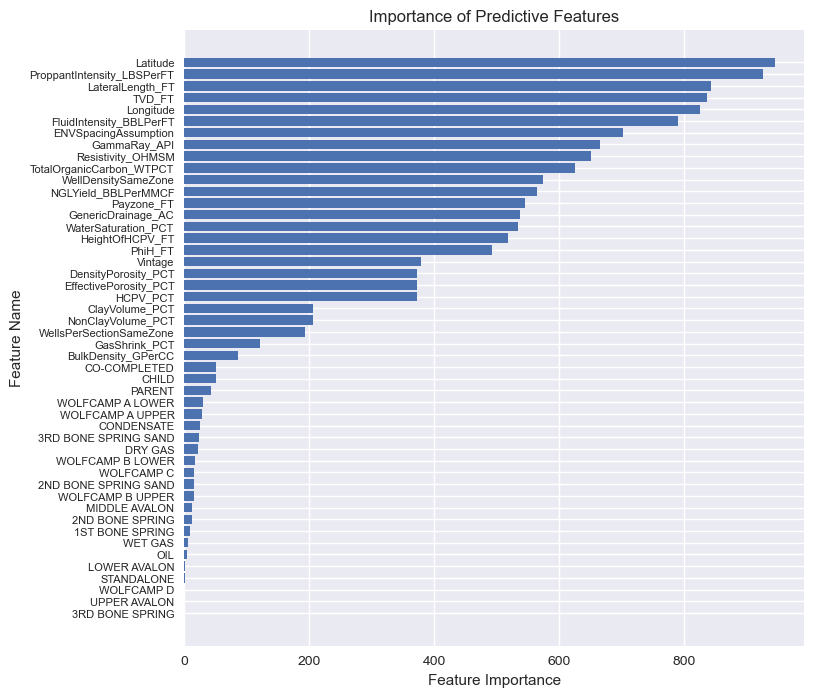

In [58]:
data = pd.DataFrame([X.columns, model.feature_importances_]).iloc[:, 1:].T
data.columns = ["Feature", "Importance"]
data = data.sort_values(by = "Importance", ascending = True)

fig = plt.figure(figsize = (8, 8))

plt.barh(data["Feature"], data["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.yticks(fontsize = 8)
plt.title("Importance of Predictive Features")